Nur nen test zu autoencodern

In [2]:
%config InlineBackend.figure_format = 'retina'

In [24]:
import tensorflow.keras as keras
from keras import layers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

In [19]:
# load image data, remove class and reshape 
data = pd.read_pickle('images_df_numerical.pkl')['data'].to_numpy()
image_size = data[0].size
samples = data.size
image_shape = (216,334,3) # height, width , channel
# reshape every row to the image and scale to 0-1
data = [row.reshape(image_shape) for row in data]
# denoise berfore training [takes some time.. like a minute or sth]:
data = [cv2.fastNlMeansDenoising(image, None, h=15, templateWindowSize=5, searchWindowSize=21) for image in data]

# scale to 0-1
data = [image.astype('float32') / 255. for image in data] 

x_train, x_test = train_test_split(data,test_size=0.2) 
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)
print("Total Number of Images:\t\t",len(data))
print("Number of Images for Training:\t",len(x_train))
print("Number of Images for Test:\t",len(x_test))

Total Number of Images:		 1531
Number of Images for Training:	 1224
Number of Images for Test:	 307


In [20]:
# cnn as en/decoder
shapes = image_shape

input_img = keras.Input(shape=shapes)

#v6
#x = layers.Conv2D(64, (7, 7), activation='relu', padding='same')(input_img)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
#x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
#x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(32, (2, 2), activation='relu', padding='same')(x)
#encoded = layers.Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# Decoder
#x = layers.Conv2D(32, (1, 1), activation='relu', padding='same')(encoded)
#x = layers.Conv2D(32, (2, 2), activation='relu', padding='same')(x)
#x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = layers.UpSampling2D((2, 2))(x)
#x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#x = layers.UpSampling2D((2, 2))(x)
#x = layers.Conv2D(shapes[2], (7, 7), activation='sigmoid', padding='same')(x)
#add cropping layer to match shapes
#decoded=layers.Cropping2D(cropping=((0,0),(0,2)))(x)

#v7
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
decoded = layers.Cropping2D(cropping=((0,0),(0,2)))(x)

autoencoder = keras.Model(input_img,decoded)
# compile autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

# train on data
autoencoder.fit(x_train,x_train,
                epochs=100,
                batch_size=100,
                shuffle=True,
                validation_split=0.2
               )

# save model
autoencoder.save('./autoencoder_files/test_autoencoder_cnn.keras')

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 216, 334, 3)]     0         
                                                                 
 conv2d_25 (Conv2D)          (None, 216, 334, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 108, 167, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 108, 167, 32)      9248      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 54, 84, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 54, 84, 32)        9248

In [21]:
# predict some images
autoencoder = keras.saving.load_model('./autoencoder_files/test_autoencoder_cnn.keras')
decoded_imgs = autoencoder.predict(x_test)

10/10 [==============================] - 1s 82ms/step


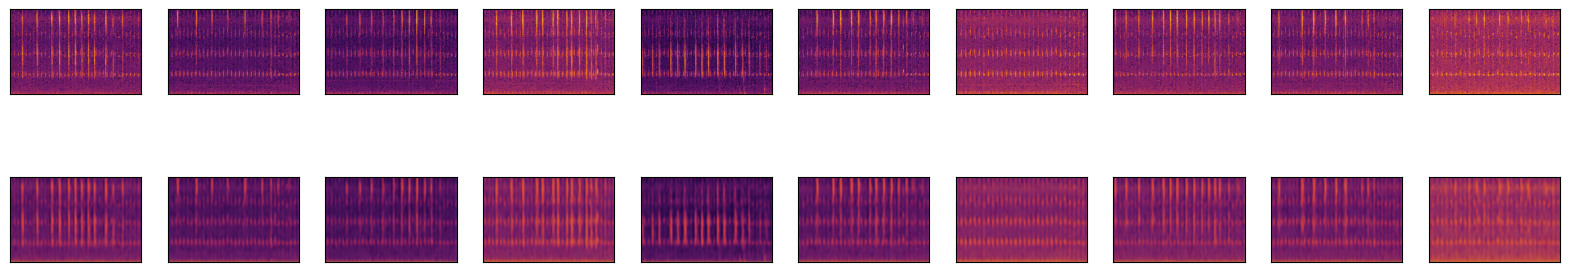

In [22]:
# display some of the images vs reconstruction
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cv2.cvtColor(x_test[i].reshape(image_shape), cv2.COLOR_BGR2RGB))
    #plt.color()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cv2.cvtColor(decoded_imgs[i].reshape(image_shape), cv2.COLOR_BGR2RGB))
    #plt.color()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig("test_autoencoder_cnn_reconstruction.png",dpi=600)